# Training, Tuning and Deployment

*In this notebook, we will be training a decision tree model and performing hyperparameter tuning. Additionally, we will create a training job to train the model, and after the hyperparameter tuning, we will deploy the model and create an endpoint*

### Import all necessary libraries

In this example, we will be using `pandas`, `numpy`, `datetime` and `time` libraries for processing our data, the `tarfile` library to package our trained model, the `boto3` and `sagemaker` libraries to interact with aws services & sagemaker (to start training & hyper-parameter jobs, and to deploy the model using endpoints) and finally a bunch of packages from the `sklearn` library for ML

In [2]:
# Packages to process data
import pandas as pd
import numpy as np
import datetime
import time

* pandas is a library for data manipulation and analysis.

* numpy is a library for numerical computing in Python. 

* datetime is a module that provides classes for working with dates, times, and time intervals. It can be used to perform arithmetic operations on dates and times and to format them for display.

* The time module provides various time-related functions, including sleeping for a specified number of seconds, getting the current time in seconds since the Epoch, and formatting time values as strings.

In [3]:
# Package to zip model file
import tarfile

* The tarfile module provides tools for working with tar archives, which are commonly used for packaging files 

In [4]:
# Packages to interact with AWS Services & Sagemaker
import boto3
import sagemaker
import os
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


* boto3 is the AWS SDK for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2.

* sagemaker is the SageMaker Python SDK, which provides high-level abstractions for working with SageMaker training jobs, models, endpoints, and more.

* os is a module that provides a portable way of using operating system dependent functionality, such as reading the environment variables and accessing the file system.

* get_execution_role is a function provided by the SageMaker SDK to get the IAM role that the notebook instance is using to access AWS resources.

* SKLearn is a SageMaker Estimator class for running scikit-learn scripts on SageMaker.

* HyperparameterTuner is a class that allows to perform hyperparameter tuning of a machine learning model, by running multiple training jobs with different hyperparameters.

* SKLearnModel is a class that allows to deploy a trained scikit-learn model on SageMaker, as a hosted endpoint.

In [5]:
# Packages for Machine Learning
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

* train_test_split is a function that splits a dataset into training and testing subsets. It randomly splits the data into two parts, one for training and the other for testing.

* DecisionTreeClassifier is a class that represents a decision tree classifier in scikit-learn. It builds a decision tree model from the training data, and can then be used to predict the class labels of new instances.

* confusion_matrix is a function that computes the confusion matrix for a classification problem. It takes as input the true labels and predicted labels, and returns a matrix that shows the number of true positives, true negatives, false positives, and false negatives. The confusion matrix is a useful tool for evaluating the performance of a classification model.

In [6]:
# Packages for Hyper-parameter tuning
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

* RepeatedKFold is a cross-validation method that splits the data into k folds, where k is a user-defined number. It repeats this process n times, where n is another user-defined number. This is useful for getting a more robust estimate of model performance by using multiple train/test splits.

* GridSearchCV is a class that performs an exhaustive search over a specified parameter grid, to find the best combination of hyperparameters for a given model. It takes as input an estimator, a parameter grid, and a cross-validation scheme, and returns a GridSearchCV object that can be fit to data to obtain the best hyperparameters.

### Setup a SageMaker Session

In this step, we will setup a SageMaker session using the `boto3` library and set the region and S3 bucket we will be using for this walkthrough. I will be setting my S3 location to be the default bucket that was created for me by SageMaker, but you can change this if you want to by giving the URL of a different S3 bucket you might want to use

In [7]:
# Setting up a sagemaker session
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session() # we can use this instance variable to invoke processes like training & tuning
s3_client = boto3.client("s3")

* boto3.client("sagemaker") creates an instance of the SageMaker client, which can be used to interact with SageMaker training jobs, models, endpoints, and other resources.

* sagemaker.Session() creates an instance of the Session class from the SageMaker SDK, which can be used to create training jobs, deploy models to endpoints, and manage SageMaker resources.

* boto3.client("s3") creates an instance of the S3 client, which can be used to interact with S3 buckets and objects. This client can be used to upload data to an S3 bucket, or download data from an S3 bucket, which can then be used for training a machine learning model on SageMaker.

In [8]:
# Get region and bucket
region = sess.boto_session.region_name
bucket = sess.default_bucket()

# Display region and bucket
print("Using bucket " + bucket + " in region " + region)

Using bucket sagemaker-eu-north-1-533267410905 in region eu-north-1


* The above line of codes retrieve the current AWS region and default S3 bucket associated with the current SageMaker session using sess.boto_session.region_name and sess.default_bucket(), respectively.

* The region variable is set to the AWS region name, which is a string that identifies the geographic location where the AWS resources associated with the current session are hosted.

* The bucket variable is set to the name of the default S3 bucket associated with the current session, which is a unique identifier that can be used to access the data stored in the bucket.

* The print statement displays the name of the bucket and the region in which it is located, so the user can verify that they are using the correct bucket and region for their purposes.

### Read the data & pre-process

Let's use the `pima_diabetes` dataset, a commonly used dataset for learning classification for this walkthrough. The feature descriptions are given below:

* _preg_  = Number of times pregnant
* _plas_  = Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* _pres_  = Diastolic blood pressure (mm Hg)
* _skin_  = Triceps skin fold thickness (mm)
* _test_  = 2-Hour serum insulin (mu U/ml)
* _mass_  = Body mass index (weight in kg/(height in m)^2)
* _pedi_  = Diabetes pedigree function
* _age_   = Age (years)
* _class_ = Class variable (1:tested positive for diabetes, 0: tested negative for diabetes)

In [9]:
df=pd.read_csv('pima.csv')
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
!aws s3 ls

2024-06-03 22:25:28 aws-may-2024
2024-06-04 14:23:08 bucket-demo-tn
2024-06-03 22:33:35 sagemaker-eu-north-1-533267410905
2024-06-03 22:33:31 sagemaker-studio-533267410905-qbwht9zwjtg


In [11]:
!aws s3 ls s3://sagemaker-eu-north-1-533267410905

                           PRE bt-decision-tree-scikit-train-2024-06-08-17-50-52-720/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-06-30-318/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-20-25-290/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-34-21-406/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-45-57-409/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-54-21-470/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-54-48-608/
                           PRE bt-decision-tree-scikit-train-2024-06-08-18-57-10-342/
                           PRE classification_example/
                           PRE pima/
                           PRE sagemaker-scikit-learn-2024-06-04-15-02-31-755/
                           PRE sagemaker-scikit-learn-2024-06-04-15-05-34-040/
                           PRE sagemaker-scikit-learn-2024-06-

In [12]:
!aws s3 cp pima.csv s3://sagemaker-eu-north-1-533267410905/pima/pima.csv

upload: ./pima.csv to s3://sagemaker-eu-north-1-533267410905/pima/pima.csv


#### Read data from S3

In [13]:
# Read data from S3 into a pandas dataframe
data = pd.read_csv(s3_client.get_object(Bucket=bucket, Key='pima/pima.csv').get("Body"))
data.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


* The above lines of code read in a CSV file named pima.csv from the S3 bucket associated with the current SageMaker session.

*Note: Upload the pima dataset into S3 bucket manually*

#### Split data and upload back to S3

In [14]:
# Split data into Train & Test dataframes
train_df, test_df = train_test_split(data, test_size=0.3, random_state=123)

# Write the train and test dataframes to sagemaker file browser
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

* The above lines of code split the data DataFrame into training and testing datasets using the train_test_split function from scikit-learn. The training dataset will be used to train the decision tree model, and the testing dataset will be used to evaluate the model's performance on unseen data.

* train_df, test_df = train_test_split(data, test_size=0.3, random_state=123) splits the data DataFrame into two parts, with 70% of the data used for training (train_df) and the remaining 30% used for testing (test_df). The random_state parameter is set to 123 to ensure that the same split is obtained every time the code is run.

* train_df.to_csv("train.csv", index=False) saves the training dataset as a CSV file named train.csv. The index=False parameter specifies that the index column should not be included in the output CSV file.

* test_df.to_csv("test.csv", index=False) saves the testing dataset as a CSV file named test.csv, with the same index=False parameter to exclude the index column.

In [15]:
# Upload train data to s3
trainpath = sess.upload_data(
    path="train.csv", bucket=bucket, key_prefix="classification_example")

# Upload test data to s3
testpath = sess.upload_data(
    path="test.csv", bucket=bucket, key_prefix="classification_example")

# Display train and test data location in s3
print(trainpath)
print(testpath)

s3://sagemaker-eu-north-1-533267410905/classification_example/train.csv
s3://sagemaker-eu-north-1-533267410905/classification_example/test.csv


* The above lines of code upload the train.csv and test.csv files to S3 using the sess.upload_data() method from the sagemaker.Session() object.

* sess.upload_data(path="train.csv", bucket=bucket, key_prefix="classification_example") uploads the train.csv file to the S3 bucket with the name bucket and key prefix classification_example. The uploaded file's S3 URI (Uniform Resource Identifier) is returned, which is stored in the trainpath variable.

* sess.upload_data(path="test.csv", bucket=bucket, key_prefix="classification_example") uploads the test.csv file to the S3 bucket with the same key prefix, and the uploaded file's S3 URI is returned, which is stored in the testpath variable.

* Finally, print(trainpath) and print(testpath) display the S3 URIs of the uploaded files in the console.

### Build models to train using a Classification Algorithm

In this step, we will first read the data from S3, split the features & target into train & test parts, and create and evaluate multiple classification models like:

* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* Gradient Boosting
* Adaptive Boosting
* K-Nearest Neighhour Classifier
* Support Vector Machine Classifier
* Naive Bayes Classifier

#### Read train & test data from s3

In [16]:
# Read training & testing datasets from s3
train_df = pd.read_csv(trainpath)
test_df = pd.read_csv(testpath)

/opt/conda/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


* The above lines of code read the data stored in the CSV files uploaded to S3 earlier using the sess.upload_data() method.

* pd.read_csv(trainpath) reads the train.csv file stored in the S3 URI specified by trainpath, and the data is stored in the train_df variable as a Pandas DataFrame.

* Similarly, pd.read_csv(testpath) reads the test.csv file stored in the S3 URI specified by testpath, and the data is stored in the test_df variable as a Pandas DataFrame.

In [17]:
# Create train dataframes with features & target
train_x = train_df.iloc[:,:8]
train_y = train_df['class']

# Create test dataframes with features & target
test_x = test_df.iloc[:,:8]
test_y = test_df['class']

* The above lines of code create train and test dataframes with features and target variables.

* train_df.iloc[:,:8] selects all rows and the first eight columns of the train_df dataframe and stores them in the train_x variable as a Pandas DataFrame. These columns represent the features of the dataset.

* train_df['class'] selects the 'class' column of the train_df dataframe, which represents the target variable, and stores it in the train_y variable as a Pandas Series.

* Similarly, test_df.iloc[:,:8] selects all rows and the first eight columns of the test_df dataframe and stores them in the test_x variable as a Pandas DataFrame. The 'class' column of the test_df dataframe is selected using test_df['class'] and stored in the test_y variable as a Pandas Series.

#### Train Classification Models using the data

NOTE: _Uncomment the model you wish to use, keep the rest commented_

In [18]:
# model = LogisticRegression(random_state=1)
model = DecisionTreeClassifier(random_state=1)
# model = RandomForestClassifier(random_state=1)
# model = GradientBoostingClassifier(random_state=1)
# model = AdaBoostClassifier(random_state=1)
# model = KNeighborsClassifier(random_state=1)
# model = SVC(random_state=1)
# model = GaussianNB(random_state=1)

* The above line of code creates a DecisionTreeClassifier object called model. DecisionTreeClassifier is a class in scikit-learn library used for building decision tree models for classification tasks.

* The random_state parameter is set to 1 to ensure that the results are reproducible across multiple runs. 

In [19]:
# Fit the training data
model.fit(train_x, train_y)

DecisionTreeClassifier(random_state=1)

* The above line of code trains the DecisionTreeClassifier model on the training data train_x and train_y.

* The fit() method is a function in scikit-learn library that is used to train the model on the training data. The training process involves finding the patterns and relationships between the input features (train_x) and the corresponding output/target values (train_y) so that the model can make accurate predictions on new, unseen data.

* After the fit() method is called, the model object will contain the learned patterns and relationships between the input features and output values.

In [20]:
# Get preditions on test data
model.predict(test_x)

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])

* model.predict(test_x) is a method used to predict the target values of the test_x data using a trained machine learning model (model).

* The method takes the test data (test_x) as input and returns an array of predicted target values. These predictions are made based on the relationships and patterns learned by the model during the training process.

#### Save predictions as a dataframe

In [21]:
# Save the predictions and actual values
predictions = pd.DataFrame(model.predict(test_x), columns=['class_pred'])
actual = test_y

# Concatenate them into a single dataframe
output = pd.concat([test_x,actual,predictions],axis=1)
# Display output
output.head()

,preg,plas,pres,skin,test,mass,pedi,age,class,class_pred
0,7,181,84,21,192,35.9,0.586,51,1,1
1,2,127,58,24,275,27.7,1.600,25,0,1
2,11,138,76,0,0,33.2,0.420,35,0,1
3,2,81,60,22,0,27.7,0.290,25,0,0
4,0,84,82,31,125,38.2,0.233,23,0,0


#### Evaluate the model using performance metrics

In [22]:
# Evaluate the model using a confusion matrix
matrix = confusion_matrix(output['class'], output['class_pred'])
# Display matrix
print(matrix)

[[111  32]
 [ 34  54]]


In [23]:
# Calculate TP, FP, FN, TN
true_neg = matrix[0][0]
fals_pos = matrix[0][1]
fals_neg = matrix[1][0]
true_pos = matrix[1][1]

**Accuracy**: 

This metric is calculated by dividing the correct predictions made by the total number of predictions made. In the context of our model, we are trying to answer the below questions:

* In how many cases did we correctly predict that a patient is at-risk of diabetes?
* In how many cases did we correctly predict that a patient is not at-risk of diabetes?

This metric is rarely used to evaluate the performance of a classification model as it can be biased towards the minority class when the data is imbalanced

In [24]:
# Calulate Accuracy Score
accuracy = (true_pos + true_neg) / (true_pos + fals_pos + fals_neg + true_neg)
# Display score
print(accuracy)

0.7142857142857143


**Precision**: 

This metric is calculated by dividing the correct positive predictions by the total number of positive predictions. In the context of our model, we are trying to answer - out of all the cases where we predicted that a patient is at-risk of diabetes, how many actually got disgnosed with diabetes?

This metric comes from the prespective of checking how good we were when predicting the positive class, but only out of all the predictions we made for the positive class. In other words, 

* I am **concerned** about how many patients were actually diagnosed with diabetes only out of the ones I predicted that were at-risk (the penalty is from predicting cases which were not actually at-risk, as being at-risk)
* I am **not concerned** about the cases where I missed out on predicting that a patient is at-risk, when actually there was evidence of diabetes after diagnosis

In [25]:
# Calculate Precision Score
precision = true_pos / (true_pos + fals_pos)
# Display score
print(precision)

0.627906976744186


**Recall**:

This metric is calculated by dividing the correct positive predictions by the total number of actual positives. In the context of our model, we are trying to answer - out of all the cases where patients were actually diagnosed with diabetes, how many did I predict were at-risk?

This metric comes from the prespective of checking how good we were with predicting the positive class, out of all the actual positive cases. In other words, 

* I am concerned about how many cases I was able to identify as at-risk out of all the patients who were diagnosed with diabetes (the penalty is from missing out on identifying a case as at-risk, when actually it was)
* I am not concerened about the cases where I wrongly predicted that a patient was at-risk, when actually there was no risk

In [26]:
# Calculate Recall Score
recall = true_pos / (true_pos + fals_neg)
# Display score
print(recall)

0.6136363636363636


**F1 score**:

The F1 score is a metric that combines the merits of both precision and recall by calculating the harmonic mean between the two of them. In other words, this score is concerned with make sure 

* We don't wrongly lable a case as at-risk when it is not (which can lead to unnecessarily treating a patient)
* We don't wrongly lable a case as not at-risk when it is (which can lead to missing out on treating a patient)

In [27]:
# Calculate F1-score
f1 = (2*precision*recall) / (precision + recall)
# Display score
print(f1)

0.6206896551724139


In [28]:
from sklearn.metrics import classification_report
#from pprint import pprint
#pprint(classification_report(output['class'], output['class_pred']))
print(classification_report(output['class'], output['class_pred']))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       143
           1       0.63      0.61      0.62        88

    accuracy                           0.71       231
   macro avg       0.70      0.69      0.70       231
weighted avg       0.71      0.71      0.71       231



### Model Tuning

A model by default is built on set internal parameters, for example, in the decision tree classifier, the `max_depth` value which tells how deep the tree must expand is set to `None` by default - which means the tree will expand until it finds all the pure leaves

This will definitely work out well for the training data, but you would be over-fitting the model if you allow the depth to go as deep as "stopping only when you find pure leaves"! Here are some of the other significant questions you can ask:

* What should be the minimum number of samples in a node to call it a leaf?
* How do you score your features on their strength to predict?
* What is the maximum number of leaf nodes? - too many leaves means you might be over-fitting

When building an ML model, you can decide what these hidden parameters must be. For Decision Tree Classifier, you can find all the hyper-parameters in this documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

**Hyper-parameter Tuning** is the art of figuring out what works best for your model - performing well statistically and aligning with your business context & needs

#### Define the parameter space & train the model

Each model is build on a different algorithm, and hence the hyper-parameters may vary. So before you tune these models, refer to the below sklearn documentations to check the parameters and modify your tuning code accordingly

* [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
* [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* [sklearn.naive_bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [29]:
# Set the parameter space / grid to tune on
params = {
    'max_depth': [2, 3, 5, 10, 20], # How deep should you expand your tree to?
    'min_samples_leaf': [5, 10, 20, 50, 100], # What is the min number of samples required to form a leaf?
    'criterion': ["gini", "entropy"] # How do you score your features on the strength to predict?
}

The params variable is a dictionary that specifies the hyperparameters to be tuned for the decision tree model.

* max_depth: It is the maximum depth of the decision tree. If not specified, nodes are expanded until all the leaves are pure or until all the leaves contain less than min_samples_split samples. This hyperparameter determines how deep the tree can go.
* min_samples_leaf: It is the minimum number of samples required to form a leaf in the decision tree. This hyperparameter determines the minimum number of samples required to form a split at each node.
* criterion: It is a measure of the quality of a split. Two options are available for criterion: Gini impurity (gini) and information gain (entropy). The default value is gini. The criterion specifies how the decision tree algorithm scores the features on their ability to predict the target variable.

In [30]:
# Set parameters for Grid Search Algorithm
grid_search = GridSearchCV(
    estimator=model, # We will be estimating the metrics using our model
    param_grid=params, # The grid we defined in the previous step
    cv=4, # The number of cross-validation folds
    n_jobs=-1, # -1 means use all CPUs to tune
    scoring = "accuracy"
)

This code sets up a GridSearchCV object, which is a way to perform a hyperparameter tuning search over a predefined parameter grid for a given estimator model.

Here are the arguments used in the code:

* estimator: The estimator object to use. This is the model we defined earlier, i.e. model.

* param_grid: A dictionary or a list of dictionaries containing the hyperparameter values to try. In this case, params is the dictionary containing the values of the hyperparameters we want to tune.

* cv: The number of cross-validation folds. In this case, the value of 4 indicates that we want to use a 4-fold cross-validation.

* n_jobs: Number of jobs to run in parallel. -1 means using all processors.

* scoring: The scoring metric to use to evaluate the performance of the model on the validation set. In this case, accuracy is used as the scoring metric.

In [31]:
# Train and Evaluate the model on all parameter combinations
grid_search.fit(train_x,train_y)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy')

* The grid_search.fit(train_x,train_y) function call is used to perform a grid search on the specified param_grid using the specified estimator or model model. It fits the model using all the possible combinations of hyperparameters defined in param_grid and returns the best set of hyperparameters that give the highest accuracy score based on the cross-validation set cv.

In [32]:
# Save the results into the dataframe
score_df = pd.DataFrame(grid_search.cv_results_)
# Get the top 5 models which have the best mean_test_score
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
42,0.005881,0.001188,0.003575,0.001104,entropy,10,20,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.740741,0.694030,0.798507,0.738806,0.743021,0.037087,1
47,0.005088,0.000190,0.002661,0.000086,entropy,20,20,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.740741,0.694030,0.798507,0.738806,0.743021,0.037087,1
17,0.005016,0.000201,0.002779,0.000114,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.740741,0.671642,0.798507,0.738806,0.737424,0.044920,3
22,0.004638,0.000065,0.002492,0.000385,gini,20,20,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.740741,0.671642,0.798507,0.738806,0.737424,0.044920,3
12,0.004677,0.000153,0.002666,0.000069,gini,5,20,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.740741,0.671642,0.791045,0.738806,0.735558,0.042431,5


#### Re-build the model & predict with the best parameters

In [33]:
# Re-build the model using the best parameters
model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_leaf=20,
    random_state=1
)

In [34]:
# Re-fit the model using the best parameters
model.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=1)

In [35]:
# Save the predictions and actual values
predictions = pd.DataFrame(model.predict(test_x), columns=['class_pred'])
actual = test_y

# Concatenate them into a single dataframe
output = pd.concat([test_x,actual,predictions],axis=1)
# Display output
output.head()

,preg,plas,pres,skin,test,mass,pedi,age,class,class_pred
0,7,181,84,21,192,35.9,0.586,51,1,1
1,2,127,58,24,275,27.7,1.600,25,0,1
2,11,138,76,0,0,33.2,0.420,35,0,1
3,2,81,60,22,0,27.7,0.290,25,0,0
4,0,84,82,31,125,38.2,0.233,23,0,0


#### Evaluate the tuned model (compare performace with baseline model)

In [36]:
# Evaluate the model using a confusion matrix
matrix = confusion_matrix(output['class'], output['class_pred'])
# Display matrix
print(matrix)

[[109  34]
 [ 27  61]]


In [37]:
# Calculate TP, FP, FN, TN
true_neg = matrix[0][0]
fals_pos = matrix[0][1]
fals_neg = matrix[1][0]
true_pos = matrix[1][1]

In [38]:
# Calulate all performance metrics - after tuning
accuracy_tuned = (true_pos + true_neg) / (true_pos + fals_pos + fals_neg + true_neg)
precision_tuned = true_pos / (true_pos + fals_pos)
recall_tuned = true_pos / (true_pos + fals_neg)

# Display performance metrics before & after tuning, and the % increment achieved
print("accuracy:  before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(accuracy,accuracy_tuned,(accuracy_tuned-accuracy)*100))
print("precision: before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(precision,precision_tuned,(precision_tuned-precision)*100))
print("recall:    before:{:0.2f}, after:{:0.2f}, %increment:{:0.2f}%".
      format(recall,recall_tuned,(recall_tuned-recall)*100))

accuracy:  before:0.71, after:0.74, %increment:2.16%
precision: before:0.63, after:0.64, %increment:1.42%
recall:    before:0.61, after:0.69, %increment:7.95%


### Model Deployment

A model is deployed when it is "fit for production use" - but what does it really mean to "deploy" a model? All you are doing is packaging the model you trained as a python code so that it can be used by a stakeholder to input newly arriving data and receive predictions to take action within the business context

This is known as creating an **Endpoint**. An endpoint is a system / node / computer / machince where your code lives, and can be triggered by giving inputs to get predictions out


### Running Training, Hyper-parameter Tuning Jobs and Deploying the model on Docker

Now that we have done training, tuning and deploying on our sagemaker local notebook, let's learn how to run these stages in the ML Lifecycle as processing jobs on Docker Containers

#### Prepare the model script to run on Docker Container

In [39]:
%%writefile model_script_docker.py

# ------------------------------
# Import all necessary libraries
# ------------------------------

# Package to take in features and hyper-parameters are inputs
import argparse

# Packages to interact with system
import time
import os
import joblib #*

# Packages to process data
import pandas as pd
import numpy as np
import datetime

# Packages for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# ---------------------------------
# Function to persist model package
# ---------------------------------

# This function will be used by the training model to creat the model package
# Use this as it is
def model_fn(model_dir): #*
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

# Main code
if __name__ == "__main__":
    
    # ----------------------------------
    # Parse test data & hyper-parameters
    # ----------------------------------
    
    parser = argparse.ArgumentParser()
    # test and train file
    parser.add_argument("--test-file", type=str, default='test.csv')
    parser.add_argument("--train-file", type=str, default="train.csv")
    # hyper-parameters
    parser.add_argument("--criterion", type=str, default="gini")
    parser.add_argument("--max-depth", type=int, default=5)
    parser.add_argument("--min-samples-leaf", type=int, default=50)
    # docker contrainer default locations
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR")) #*
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN")) #*
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST")) #*

    args = parser.parse_args()

    # --------------------------
    # Build classification model
    # --------------------------

    # Read training & testing datasets from s3
    train_df = pd.read_csv(os.path.join(args.train, args.train_file)) #*
    test_df = pd.read_csv(os.path.join(args.test, args.test_file)) #*

    # Create train dataframes with features & target
    train_x = train_df.iloc[:,:8]
    train_y = train_df['class']

    # Create test dataframes with features & target
    test_x = test_df.iloc[:,:8]
    test_y = test_df['class']

    # Build model using the best parameters
    model = DecisionTreeClassifier(
        criterion=args.criterion, #*
        max_depth=args.max_depth, #*
        min_samples_leaf=args.min_samples_leaf, #*
        random_state=1
    )

    # Fit model
    model.fit(train_x, train_y)

    # -----------------------
    # Predict using the model
    # -----------------------

    print("running model for predictions...")
    time.sleep(2)

    # Save the predictions and actual values
    predictions = pd.DataFrame(model.predict(test_x), columns=['class_pred'])
    actual = test_y

    # Concatenate them into a single dataframe
    output = pd.concat([test_x,actual,predictions],axis=1)
    # Display output
    # output.head()

    # --------------------
    # Evaluate Performnace
    # --------------------

    print("evaluating model performance...")
    time.sleep(2)

    # Evaluate the model using a confusion matrix
    matrix = confusion_matrix(output['class'], output['class_pred'])
    # Display matrix
    # print(matrix)

    # Calculate TP, FP, FN, TN
    true_neg = matrix[0][0]
    fals_pos = matrix[0][1]
    fals_neg = matrix[1][0]
    true_pos = matrix[1][1]

    # Calulate all performance metrics - after tuning
    accuracy = (true_pos + true_neg) / (true_pos + fals_pos + fals_neg + true_neg)
    precision = true_pos / (true_pos + fals_pos)
    recall = true_pos / (true_pos + fals_neg)

    # Display performance metrics before & after tuning, and the % increment achieved
    print("accuracy:{}".format(accuracy))
    print("precision:{}".format(precision))
    print("recall:{}".format(recall))

    # ------------------------
    # Save model package file
    # ------------------------

    # persist model
    path = os.path.join(args.model_dir, "model.joblib") #*
    joblib.dump(model, path)
    print("model persisted at " + path)

Overwriting model_script_docker.py


* The above cell is a Python script for training a decision tree classification model on a given dataset and persisting the trained model as a joblib file. It can be run in a Docker container to facilitate reproducibility and scalability of the model training process.

* The script imports the necessary Python libraries such as argparse, time, os, joblib, pandas, numpy, datetime, and scikit-learn. It defines a function called model_fn that loads the persisted model from the joblib file.

* In the main function, the script parses the input arguments including the filenames for the training and testing datasets, hyperparameters for the decision tree model, and the locations of the model directory, train and test directories (in a Docker container). It reads the training and testing datasets from the input file paths and extracts the feature columns and target column for each dataset.

* The script then initializes a decision tree classifier model with the given hyperparameters, fits the model on the training dataset, and uses the fitted model to predict the target variable for the testing dataset. It evaluates the performance of the model using the confusion matrix and calculates the accuracy, precision, and recall metrics. Finally, it saves the trained model to the model directory as a joblib file.

* When the script is run, it first parses the input arguments, loads the training and testing datasets, trains the decision tree model, predicts the target variable for the testing dataset, evaluates the performance of the model, and saves the trained model to the specified model directory. The script can be run in a Docker container, allowing for easy replication and scaling of the model training process.

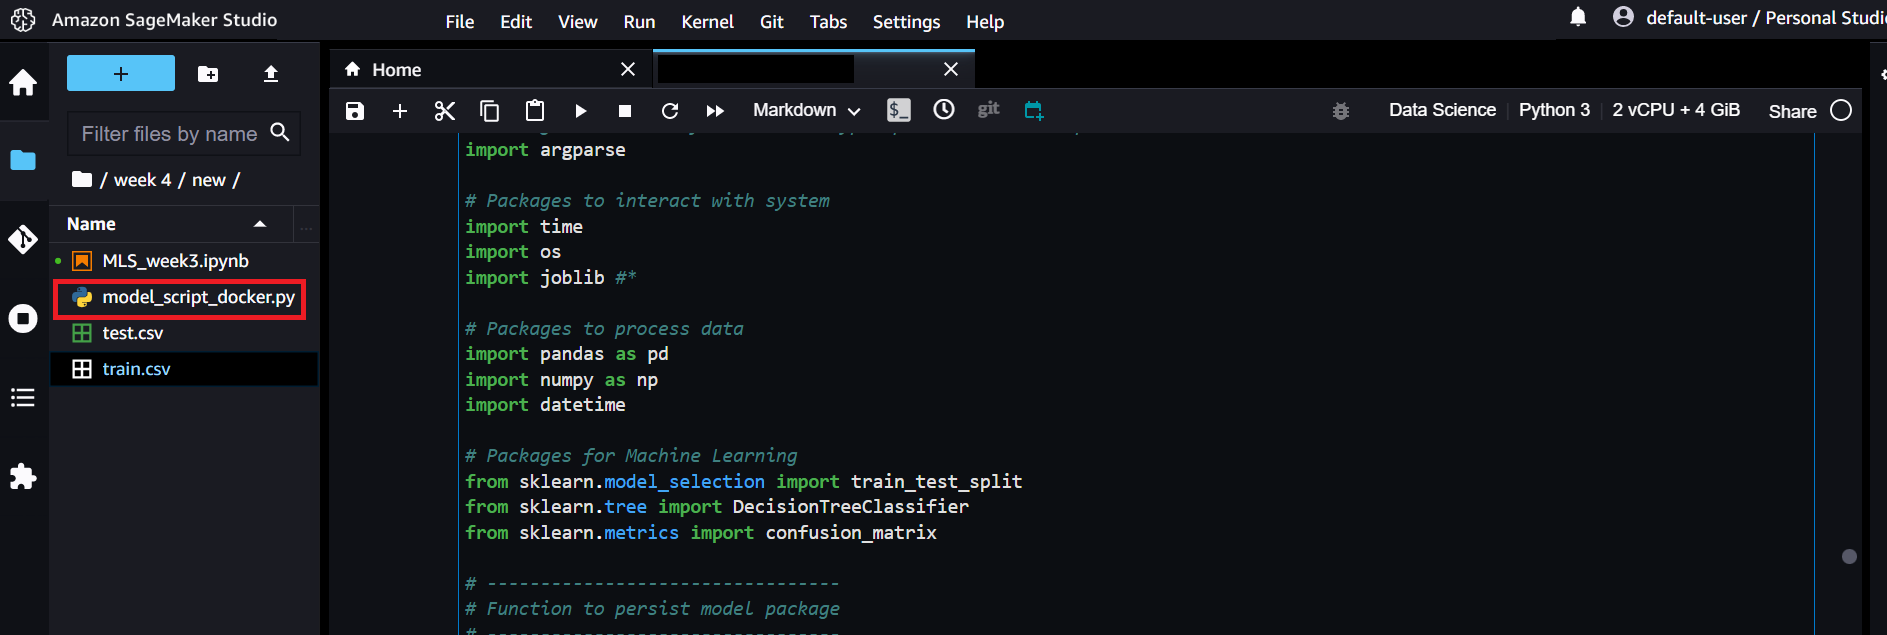

#### Train the model using SageMaker Estimator Function

In [41]:
# Import library to train model
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

# Set framework version (stable)
FRAMEWORK_VERSION = "0.23-1"

# Creat the sklearn estimator instance
sklearn_estimator = SKLearn(
    entry_point="model_script_docker.py", # your model code
    role=get_execution_role(), # the default IAM role used
    instance_count=1, # number of nodes
    instance_type="ml.m5.xlarge", # EC2 instance type
    framework_version=FRAMEWORK_VERSION, # Framework version
    base_job_name="bt-decision-tree-scikit-train", # Prefix of the job name
    hyperparameters={ # Hyper-parameters
        "criterion":"gini",
        "max-depth":5,
        "min-samples-leaf":50
    }
)

* The above code defines an AWS SageMaker estimator for training a scikit-learn decision tree model. Here are the key parameters and arguments:

* entry_point: This specifies the path to the Python script that contains the model code. In this case, it is set to model_script_docker.py.

* role: This specifies the AWS IAM role used to run the training job. The get_execution_role() function is used to obtain the default role associated with the notebook instance.

* instance_count: This specifies the number of EC2 instances to use for training. In this case, it is set to 1.

* instance_type: This specifies the type of EC2 instance to use for training. In this case, it is set to ml.m4.xlarge.

* framework_version: This specifies the version of scikit-learn to use. In this case, it is set to "0.23-1".

* base_job_name: This specifies the base name of the training job. A unique job name will be generated by appending a timestamp and a random string to the base name.

* hyperparameters: This specifies the hyperparameters to use for training. In this case, the hyperparameters are criterion, max-depth, and min-samples-leaf, with values of "gini", 5, and 50, respectively.

In [42]:
# Launch Training Job
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: bt-decision-tree-scikit-train-2024-06-08-19-04-03-371


2024-06-08 19:04:03 Starting - Starting the training job...
2024-06-08 19:04:21 Starting - Preparing the instances for training...
2024-06-08 19:04:58 Downloading - Downloading the training image...
2024-06-08 19:05:23 Training - Training image download completed. Training in progress..2024-06-08 19:05:32,412 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-06-08 19:05:32,415 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-08 19:05:32,455 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-06-08 19:05:32,606 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-08 19:05:32,617 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-08 19:05:32,629 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-08 19:05:32,638 sagemaker-training-toolkit INFO     Invoking user 

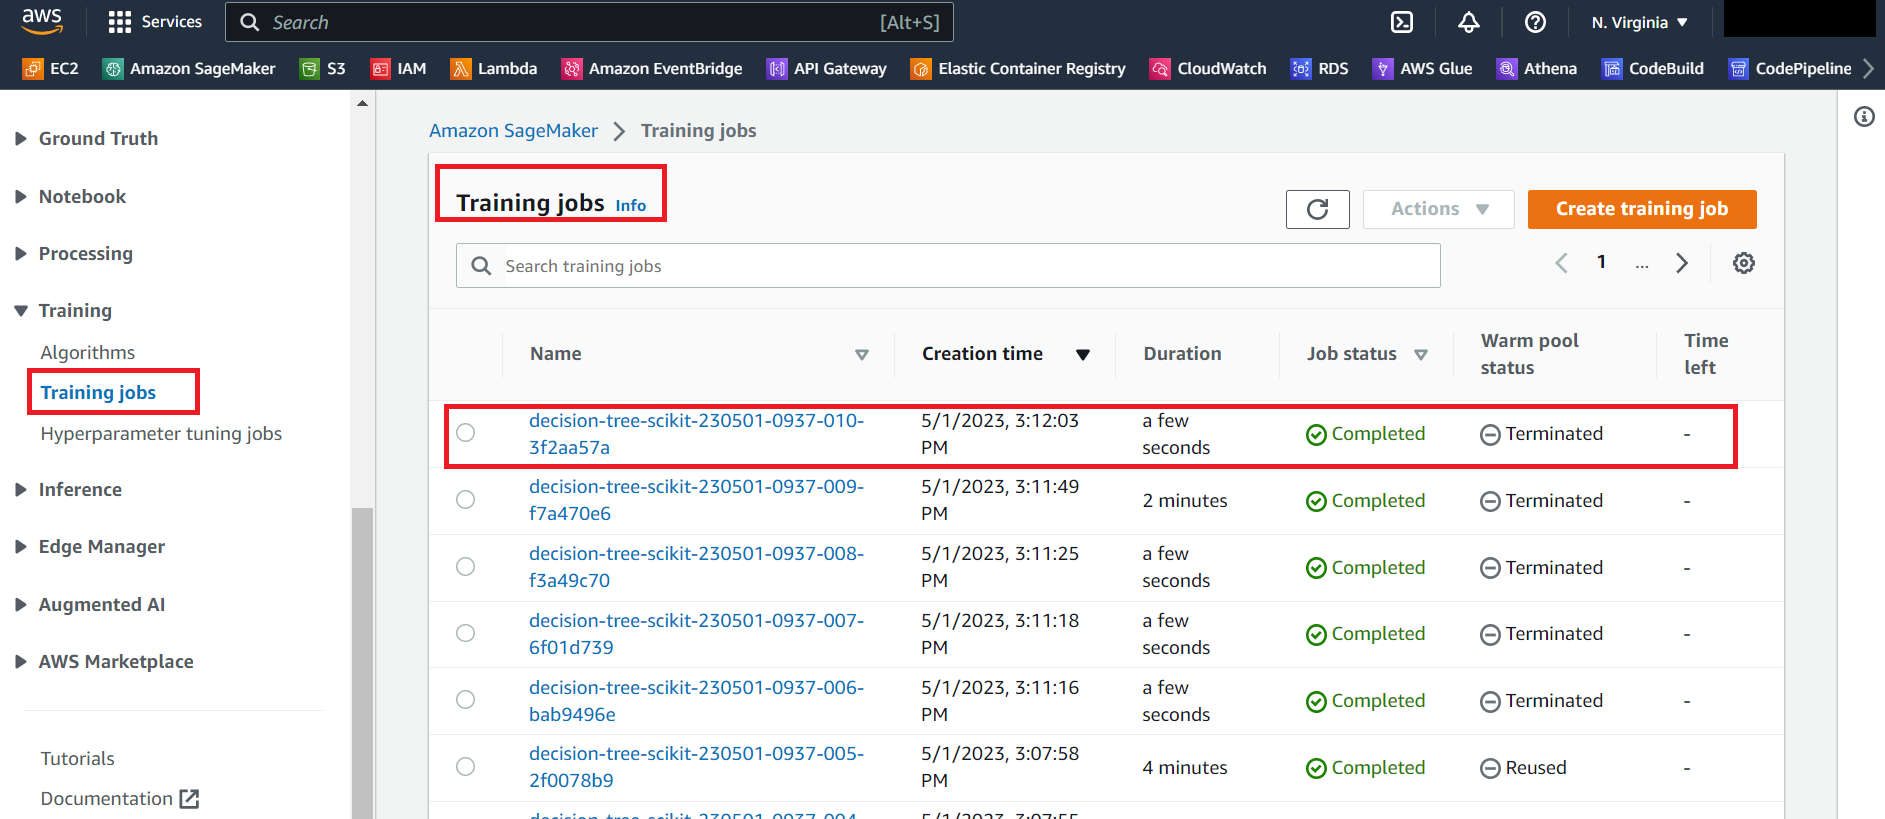

#### Tune the model using SageMaker Tuner Function

In [43]:
# Library to tune models
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "max-depth": IntegerParameter(20,50),
    "min-samples-leaf": IntegerParameter(50,60)
}

# Create an optimizer instance
sklearn_optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator, # model training instance
    hyperparameter_ranges=hyperparameter_ranges, # parameter space
    base_tuning_job_name="decision-tree-scikit-tune", # Prefix of the tuning job
    objective_type="Maximize", 
    objective_metric_name="accuracy",
    max_jobs=10,
    max_parallel_jobs=5,
    metric_definitions=[
        {"Name": "accuracy", "Regex": "accuracy:([0-9.]+).*$"} # search logs on cloudwatch
    ],
)

* The above code sets up a hyperparameter tuning job using SageMaker's HyperparameterTuner. The hyperparameter ranges are defined in the dictionary hyperparameter_ranges. The sklearn_optimizer instance is used to configure the tuning job.

* The estimator parameter specifies the estimator instance used for training the model. The hyperparameter_ranges parameter is used to define the ranges of hyperparameters that should be explored. The base_tuning_job_name parameter is a string prefix for the name of the tuning job. The objective_type parameter specifies whether to maximize or minimize the value of the objective metric. In this case, it is set to "Maximize". The objective_metric_name parameter is the name of the metric to optimize. The max_jobs parameter specifies the maximum number of tuning jobs to run. The max_parallel_jobs parameter specifies the maximum number of jobs to run in parallel. Finally, the metric_definitions parameter is used to define the metrics that should be collected during training.

In [44]:
sklearn_optimizer.fit({"train": trainpath, "test": testpath})

INFO:sagemaker:Creating hyperparameter tuning job with name: decision-tree-scikit-240608-1911


........................................!


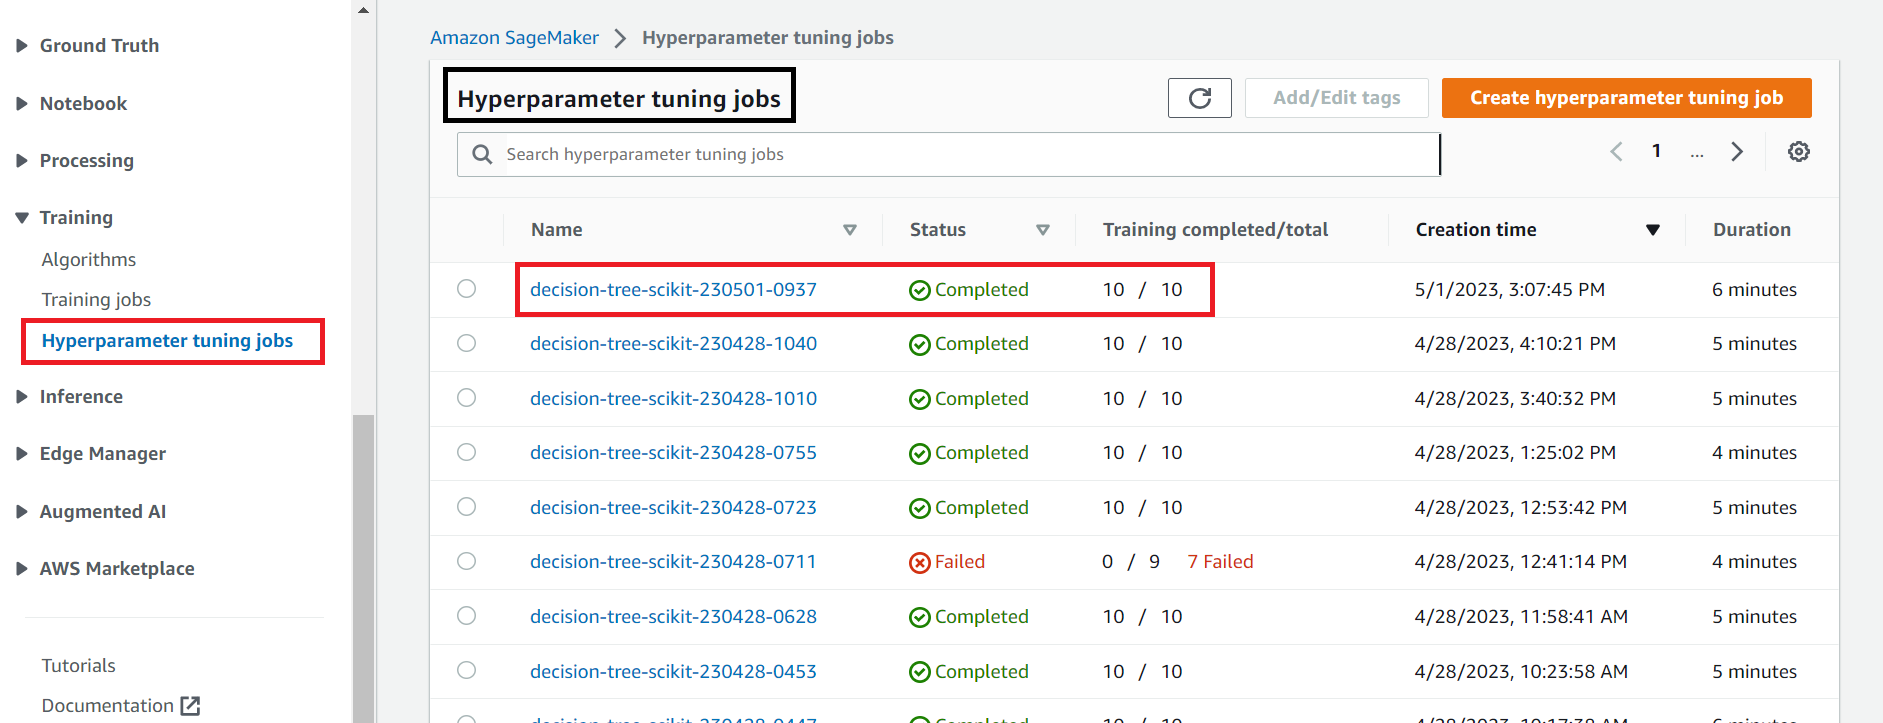

In [45]:
# Get the tuner results in a df
results = sklearn_optimizer.analytics().dataframe()
results

,max-depth,min-samples-leaf,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,50.0,60.0,decision-tree-scikit-240608-1911-010-ef604855,Completed,0.779221,2024-06-08 19:13:44+00:00,2024-06-08 19:14:18+00:00,34.0
1,50.0,51.0,decision-tree-scikit-240608-1911-009-6bab579f,Completed,0.779221,2024-06-08 19:13:40+00:00,2024-06-08 19:14:13+00:00,33.0
2,50.0,50.0,decision-tree-scikit-240608-1911-008-2852edd1,Completed,0.783550,2024-06-08 19:13:31+00:00,2024-06-08 19:14:04+00:00,33.0
3,49.0,50.0,decision-tree-scikit-240608-1911-007-f4ee4078,Completed,0.783550,2024-06-08 19:13:31+00:00,2024-06-08 19:14:04+00:00,33.0
4,21.0,50.0,decision-tree-scikit-240608-1911-006-4cb5b904,Completed,0.783550,2024-06-08 19:13:36+00:00,2024-06-08 19:14:10+00:00,34.0
5,38.0,51.0,decision-tree-scikit-240608-1911-005-4b8bc418,Completed,0.779221,2024-06-08 19:12:06+00:00,2024-06-08 19:13:20+00:00,74.0
6,35.0,54.0,decision-tree-scikit-240608-1911-004-eeabb1fd,Completed,0.779221,2024-06-08 19:11:51+00:00,2024-06-08 19:13:10+00:00,79.0
7,30.0,54.0,decision-tree-scikit-240608-1911-003-fe65e78f,Completed,0.779221,2024-06-08 19:12:08+00:00,2024-06-08 19:13:26+00:00,78.0
8,29.0,54.0,decision-tree-scikit-240608-1911-002-f3f95550,Completed,0.779221,2024-06-08 19:11:45+00:00,2024-06-08 19:13:04+00:00,79.0
9,27.0,56.0,decision-tree-scikit-240608-1911-001-e1a94305,Completed,0.779221,2024-06-08 19:11:47+00:00,2024-06-08 19:13:01+00:00,74.0


* The above code will return a Pandas dataframe containing the results of the hyperparameter tuning job. The dataframe will have columns such as the hyperparameters tested, the values tested, the training and validation metrics, and other metadata about the tuning job.

#### Deploy the model using SageMaker Model Deploy Function

In [46]:
# Save the model artefact into a variable
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

Model artifact persisted at s3://sagemaker-eu-north-1-533267410905/bt-decision-tree-scikit-train-2024-06-08-19-04-03-371/output/model.tar.gz


* The above code retrieves the S3 location of the trained model artifact from the latest training job of the sklearn_estimator. The boto3 SageMaker client is used to call the describe_training_job function to get information about the latest training job. The S3 location of the trained model artifact is extracted from the response and stored in the artifact variable. Finally, the S3 location of the model artifact is printed.

In [47]:
# Import library to deploy model
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact, # The model zip file the training job generated
    role=get_execution_role(), # Default IAM role
    entry_point="model_script_docker.py", # Model Code
    framework_version=FRAMEWORK_VERSION
)

In [50]:
# Deploy SKLearn Predictor
sklearn_predictor = model.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-06-08-19-18-52-780
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-06-08-19-18-53-437
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-06-08-19-18-53-437


-----!

In [51]:
sklearn_predictor.predict(test_x)

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [52]:
# Save predictions as output dataframe
predictions = pd.DataFrame(sklearn_predictor.predict(test_x), columns=['class_pred'])
actual = test_y

output = pd.concat([test_x,test_y,predictions],axis=1)

In [53]:
output

,preg,plas,pres,skin,test,mass,pedi,age,class,class_pred
0,7,181,84,21,192,35.9,0.586,51,1,1
1,2,127,58,24,275,27.7,1.600,25,0,0
2,11,138,76,0,0,33.2,0.420,35,0,1
3,2,81,60,22,0,27.7,0.290,25,0,0
4,0,84,82,31,125,38.2,0.233,23,0,0
...,...,...,...,...,...,...,...,...,...,...
226,2,107,74,30,100,33.6,0.404,23,0,0
227,3,180,64,25,70,34.0,0.271,26,0,1
228,0,125,96,0,0,22.5,0.262,21,0,0
229,1,121,78,39,74,39.0,0.261,28,0,0


In [54]:
# Evaluate the model using a confusion matrix
matrix = confusion_matrix(output['class'], output['class_pred'])
# Display matrix
# print(matrix)

# Calculate TP, FP, FN, TN
true_neg = matrix[0][0]
fals_pos = matrix[0][1]
fals_neg = matrix[1][0]
true_pos = matrix[1][1]

# Calulate all performance metrics - after tuning
accuracy = (true_pos + true_neg) / (true_pos + fals_pos + fals_neg + true_neg)
precision = true_pos / (true_pos + fals_pos)
recall = true_pos / (true_pos + fals_neg)

# Display performance metrics before & after tuning, and the % increment achieved
print("accuracy:{}".format(accuracy))
print("precision:{}".format(precision))
print("recall:{}".format(recall))

accuracy:0.7835497835497836
precision:0.7567567567567568
recall:0.6363636363636364


#### Delete the Endpoint

**Important!** An Endpoint is a LIVE node which is always running, ready to process & predict to give you output. So unless you are making real-time predictions on streaming data, delete your endpoints after use

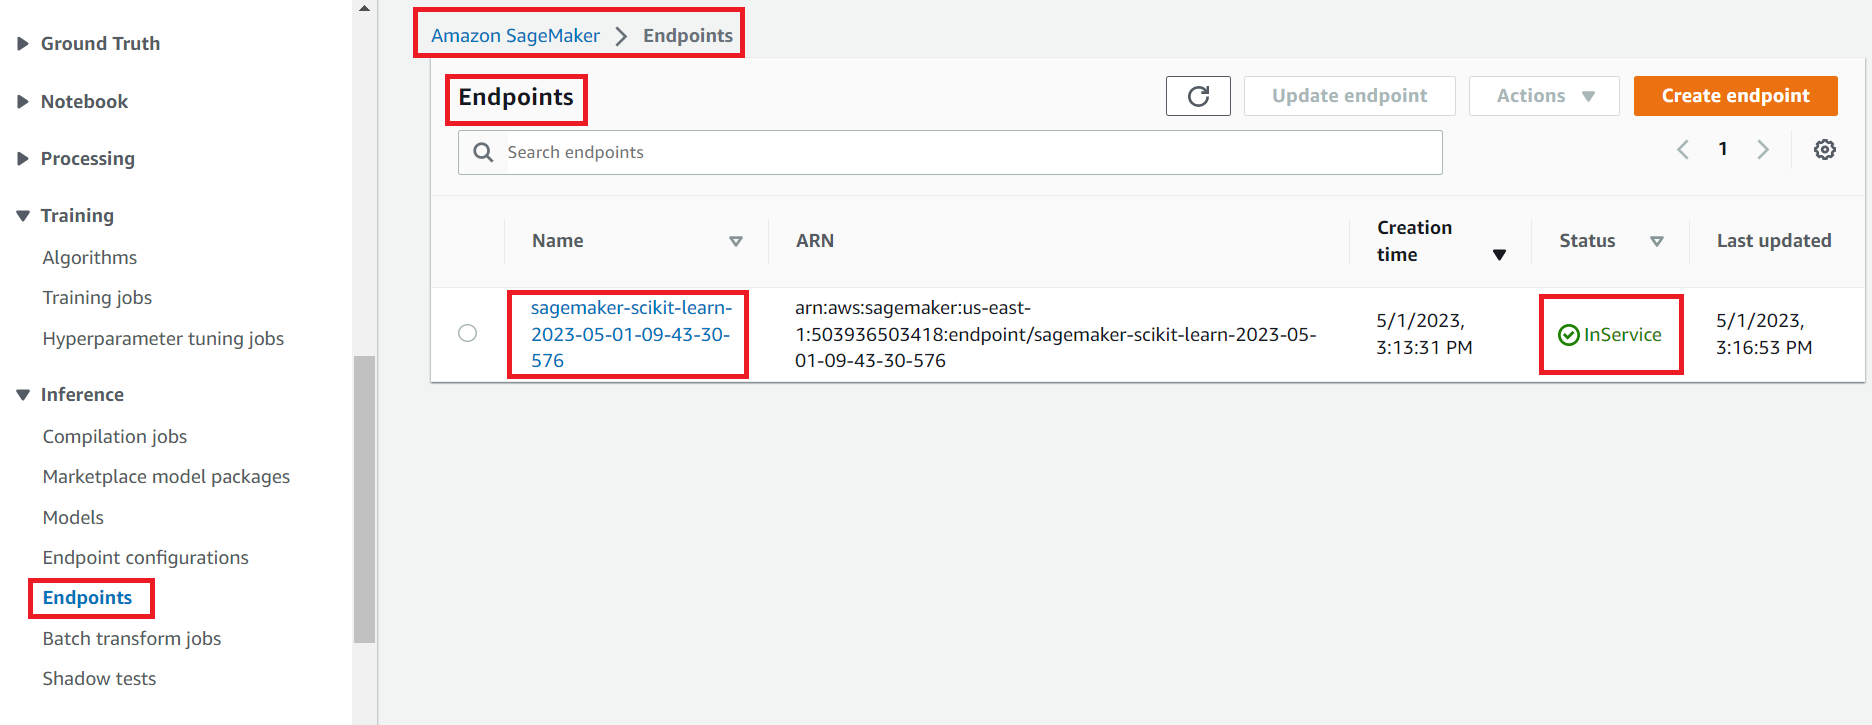

In [ ]:
# sm_boto3.delete_endpoint(EndpointName=sklearn_predictor.endpoint)

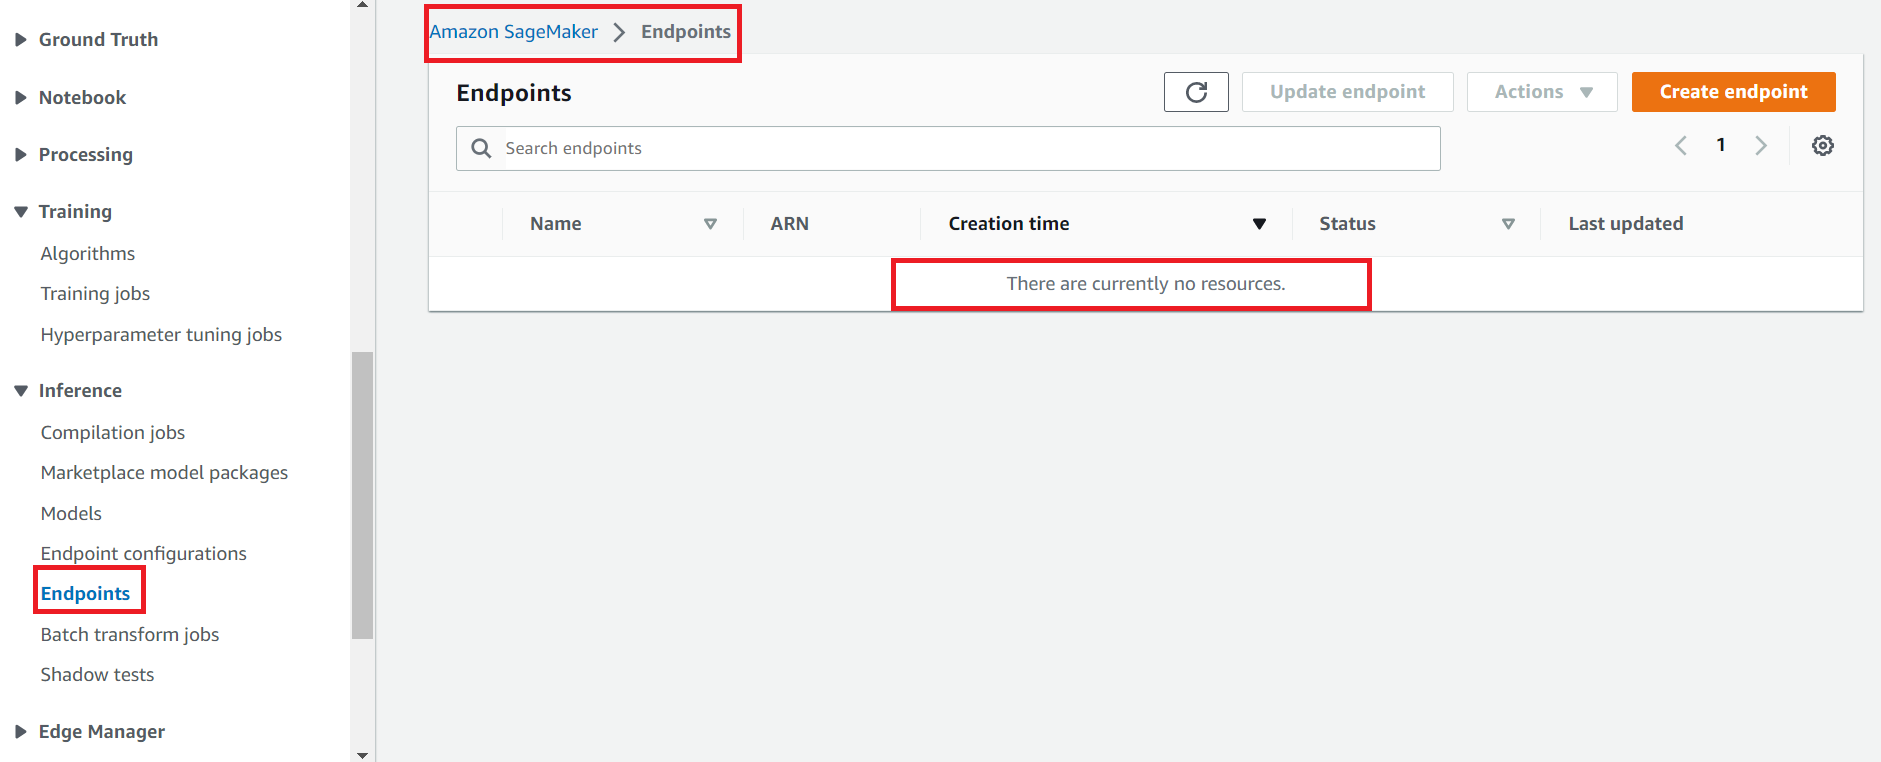